# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# Using prettyTable for showing the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer", "Model", "Hyperparameters", "AUC Score"]
print(table)

+------------+-------+-----------------+-----------+
| Vectorizer | Model | Hyperparameters | AUC Score |
+------------+-------+-----------------+-----------+
+------------+-------+-----------------+-----------+


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


# We are taking 60k positive and negative points to keep data balanced
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score in (1,2) LIMIT 30000 """, con) 
filtered_data = filtered_data.append(
                    pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score in (4,5) LIMIT 30000 """, con))

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(52673, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.78833333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(52673, 10)


1    28165
0    24508
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I give five stars to the Maurice Sendak story. One star for this printed edition of the book.<br />My children had an older copy this book, so I was very familiar with the previous softcover version. I ordered this for my granddaughters, but I'm embarrassed to give it as a gift, it looks so puny. The book is about the size of a postcard and I think it's overpriced. I've learned my lesson: I will not be buying any more softcover children books, next time I'll get a used copy.
Reality strikes.  I have been drinking this tea every night for 10 years !  It is the best thing to keep me on the straight n narrow!
This lefse' isn't even worth one star, but that was the lowest Amazon would let me go.  There is no flavor to it what-so-ever.  You can't taste the potatoes or the butter, all you taste is flour and it's very dry.  It used to be better years ago when it slightly resembled the taste of potatoes, but as it is with many items, they must have found ways to save a buck at the expense of t

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I give five stars to the Maurice Sendak story. One star for this printed edition of the book.<br />My children had an older copy this book, so I was very familiar with the previous softcover version. I ordered this for my granddaughters, but I'm embarrassed to give it as a gift, it looks so puny. The book is about the size of a postcard and I think it's overpriced. I've learned my lesson: I will not be buying any more softcover children books, next time I'll get a used copy.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I give five stars to the Maurice Sendak story. One star for this printed edition of the book.My children had an older copy this book, so I was very familiar with the previous softcover version. I ordered this for my granddaughters, but I'm embarrassed to give it as a gift, it looks so puny. The book is about the size of a postcard and I think it's overpriced. I've learned my lesson: I will not be buying any more softcover children books, next time I'll get a used copy.
Reality strikes.  I have been drinking this tea every night for 10 years !  It is the best thing to keep me on the straight n narrow!
This lefse' isn't even worth one star, but that was the lowest Amazon would let me go.  There is no flavor to it what-so-ever.  You can't taste the potatoes or the butter, all you taste is flour and it's very dry.  It used to be better years ago when it slightly resembled the taste of potatoes, but as it is with many items, they must have found ways to save a buck at the expense of the qua

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This lefse' is not even worth one star, but that was the lowest Amazon would let me go.  There is no flavor to it what-so-ever.  You can not taste the potatoes or the butter, all you taste is flour and it is very dry.  It used to be better years ago when it slightly resembled the taste of potatoes, but as it is with many items, they must have found ways to save a buck at the expense of the quality & flavor.  Do not waste your money!  You are better off investing in the equipment to make your own, or finding a website that sells an authentic "home-made" variety.  I grew up in a Scandinavian household that made traditional lefse' for family gatherings, trust me when I say Mrs Olson is is absolutely horrible.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I give five stars to the Maurice Sendak story. One star for this printed edition of the book.<br />My children had an older copy this book, so I was very familiar with the previous softcover version. I ordered this for my granddaughters, but I'm embarrassed to give it as a gift, it looks so puny. The book is about the size of a postcard and I think it's overpriced. I've learned my lesson: I will not be buying any more softcover children books, next time I'll get a used copy.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This lefse is not even worth one star but that was the lowest Amazon would let me go There is no flavor to it what so ever You can not taste the potatoes or the butter all you taste is flour and it is very dry It used to be better years ago when it slightly resembled the taste of potatoes but as it is with many items they must have found ways to save a buck at the expense of the quality flavor Do not waste your money You are better off investing in the equipment to make your own or finding a website that sells an authentic home made variety I grew up in a Scandinavian household that made traditional lefse for family gatherings trust me when I say Mrs Olson is is absolutely horrible 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)   # adding 0-9 in the regex
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 52673/52673 [00:17<00:00, 3041.04it/s]


In [24]:
preprocessed_reviews[1500]

'lefse not even worth one star lowest amazon would let go no flavor ever not taste potatoes butter taste flour dry used better years ago slightly resembled taste potatoes many items must found ways save buck expense quality flavor not waste money better investing equipment make finding website sells authentic home made variety grew scandinavian household made traditional lefse family gatherings trust say mrs olson absolutely horrible'

In [25]:
len(preprocessed_reviews)

52673

(array([1.600e+02, 3.100e+01, 1.510e+02, 6.100e+02, 1.682e+03, 2.658e+03,
        3.031e+03, 3.014e+03, 2.819e+03, 2.656e+03, 2.426e+03, 2.192e+03,
        1.907e+03, 1.943e+03, 1.841e+03, 1.737e+03, 1.625e+03, 1.400e+03,
        1.369e+03, 1.267e+03, 1.181e+03, 1.060e+03, 1.025e+03, 9.300e+02,
        8.470e+02, 8.370e+02, 7.260e+02, 7.030e+02, 6.440e+02, 6.120e+02,
        5.750e+02, 5.110e+02, 4.760e+02, 4.910e+02, 4.090e+02, 4.300e+02,
        3.280e+02, 3.460e+02, 3.330e+02, 3.280e+02, 2.760e+02, 2.570e+02,
        2.370e+02, 2.420e+02, 2.040e+02, 2.040e+02, 2.050e+02, 1.740e+02,
        1.580e+02, 1.570e+02, 1.320e+02, 1.560e+02, 1.370e+02, 1.390e+02,
        1.140e+02, 1.200e+02, 9.900e+01, 9.700e+01, 8.900e+01, 1.150e+02,
        9.300e+01, 7.300e+01, 6.600e+01, 6.300e+01, 7.700e+01, 5.800e+01,
        7.200e+01, 5.100e+01, 4.500e+01, 6.700e+01, 5.500e+01, 5.900e+01,
        4.900e+01, 3.200e+01, 3.800e+01, 3.800e+01, 4.100e+01, 4.300e+01,
        4.100e+01, 3.000e+01, 2.700e+0

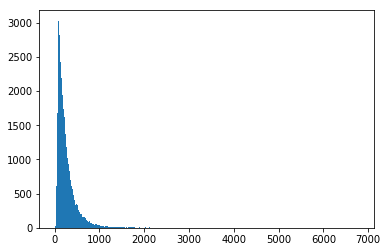

In [26]:
plt.hist([len(x) for x in preprocessed_reviews], bins=len(preprocessed_reviews)//100)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 52673/52673 [00:10<00:00, 4996.13it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
# importing train_test_split to split data for kNN

from sklearn.model_selection import train_test_split

In [29]:
#BoW
# this is random splitting into train, test and cross validation set
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_reviews, review_score, 
                                                                    test_size=0.33, random_state = 0) 
ppReview_cv, ppReview_test, rs_cv, rs_test = train_test_split(ppReview_test, rs_test, test_size=0.50, 
                                                              random_state=0)
count_vect = CountVectorizer(min_df=10, max_features=500)    #in scikit-learn
count_vect.fit(ppReview_train)    # fitting done only on training set
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", count_vect.get_feature_names()[:10])

print('='*50)

bow_train = count_vect.transform(ppReview_train)
bow_cv = count_vect.transform(ppReview_cv)
bow_test = count_vect.transform(ppReview_test)

print("\nShapes After Vectorization ")
print(bow_train.shape, len(rs_train))
print(bow_cv.shape, len(rs_cv))
print(bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

Total training features :  500
some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']

Shapes After Vectorization 
(35290, 500) 35290
(8691, 500) 8691
(8692, 500) 8692
Unique words in training :  500


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (52673, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [31]:
#tf-IDF
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(ppReview_train)
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

tfIdf_train = tf_idf_vect.transform(ppReview_train)
tfIdf_cv = tf_idf_vect.transform(ppReview_cv)
tfIdf_test = tf_idf_vect.transform(ppReview_test)
print("\nShapes After Vectorization ")
print(tfIdf_train.shape, len(rs_train))
print(tfIdf_cv.shape, len(rs_cv))
print(tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Total training features :  500
some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']

Shapes After Vectorization 
(35290, 500) 35290
(8691, 500) 8691
(8692, 500) 8692
Unique words in training :  500


## [4.4] Word2Vec

In [47]:
# Train your own Word2Vec model using your own text corpus
i=0
# list of sentences divide into train, test and cross validation set
list_of_sentance_train=[sentance.split() for sentance in ppReview_train]
list_of_sentance_cv=[sentance.split() for sentance in ppReview_cv]
list_of_sentance_test=[sentance.split() for sentance in ppReview_test]

In [48]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # training the word2Vec model only on the train dataset
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8250088095664978), ('excellent', 0.7423622012138367), ('perfect', 0.7097649574279785), ('wonderful', 0.7050350904464722), ('makes', 0.7005448937416077), ('well', 0.6867148280143738), ('love', 0.6747015714645386), ('delicious', 0.6628507375717163), ('decent', 0.6592996120452881), ('awesome', 0.6547524929046631)]
[('ever', 0.8932048082351685), ('misfortune', 0.8682041168212891), ('eaten', 0.8630183935165405), ('hottest', 0.8468180298805237), ('lover', 0.842382550239563), ('liked', 0.839311957359314), ('repulsive', 0.8293436169624329), ('fantasicakes', 0.8267478942871094), ('favorites', 0.8228455185890198), ('awful', 0.8225680589675903)]


In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7269
sample words  ['discount', 'tommy', 'best', 'popcorn', 'needs', 'great', 'northern', 'better', 'others', 'tea', 'good', 'even', 'adding', 'hot', 'boiling', 'water', 'aroma', 'pleasing', 'enjoy', 'without', 'sugar', 'sometimes', 'milk', 'though', 'not', 'sweet', 'taste', 'iv', 'e', 'tried', 'different', 'gluten', 'free', 'breads', 'left', 'lot', 'desired', 'ate', 'stumbled', 'across', 'brand', 'bread', 'mix', 'yet', 'really', 'liked', 'ordered', 'made', 'plain', 'cheese']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review in the train, test and CV set.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 
#                             # if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

sent_vectors_train, sent_vectors_test, sent_vectors_cv = [],[],[]
for i, aset in enumerate([list_of_sentance_train, list_of_sentance_cv, list_of_sentance_test]):
    if i==0:
        print("Working on training set")
    elif i==1:
        print("Working on cross validation set")
    elif i==2:
        print("Working on test set")
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length 50
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        if i==0:
            sent_vectors_train.append(sent_vec)
        elif i==1:
            sent_vectors_cv.append(sent_vec)
        elif i==2:
            sent_vectors_test.append(sent_vec)
            
print("Sentences Vectors created..")

Working on training set
Working on cross validation set
Working on test set
Sentences Vectors created..


In [36]:
# Average Word2Vec

avgWV_vect_train = sent_vectors_train
avgWV_vect_cv = sent_vectors_cv
avgWV_vect_test = sent_vectors_test
print("Total training features : ", len(avgWV_vect_train[0]))
print('='*50)

print("\nShapes After Vectorization ")
print("Train Set : (", len(avgWV_vect_train), len(avgWV_vect_train[0]), ")")
print("Test Set : (", len(avgWV_vect_test), len(avgWV_vect_test[0]), ")")
print("CV Set : (", len(avgWV_vect_cv), len(avgWV_vect_cv[0]), ")")

Total training features :  50

Shapes After Vectorization 
Train Set : ( 35290 50 )
Test Set : ( 8692 50 )
CV Set : ( 8691 50 )


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10, max_features=500)
# fit transform only on training set
tf_idf_matrix = model.fit_transform(ppReview_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

tfsent_vectors_train, tfsent_vectors_test, tfsent_vectors_cv = [],[],[]
for i, aset in enumerate([list_of_sentance_train, list_of_sentance_cv, list_of_sentance_test]):
    if i==0:
        print("Working on training set")
    elif i==1:
        print("Working on cross validation set")
    elif i==2:
        print("Working on test set")
    rows=0
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length 50
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        if i==0:
            tfsent_vectors_train.append(sent_vec)
        elif i==1:
            tfsent_vectors_cv.append(sent_vec)
        elif i==2:
            tfsent_vectors_test.append(sent_vec)
        rows+=1
            
print("Sentences Vectors created..")

Working on training set
Working on cross validation set
Working on test set
Sentences Vectors created..


In [39]:
# Tf-IDF Weighted Word2Vec

tfIdfWV_vect_train = tfsent_vectors_train
tfIdfWV_vect_cv = tfsent_vectors_cv
tfIdfWV_vect_test = tfsent_vectors_test
print("Total training features : ", len(tfIdfWV_vect_train[0]))
print('='*50)

print("\nShapes After Vectorization ")
print("Train Set : (", len(tfIdfWV_vect_train), len(tfIdfWV_vect_train[0]), ")")
print("Test Set : (", len(tfIdfWV_vect_test), len(tfIdfWV_vect_test[0]), ")")
print("CV Set : (", len(tfIdfWV_vect_cv), len(tfIdfWV_vect_cv[0]), ")")

Total training features :  50

Shapes After Vectorization 
Train Set : ( 35290 50 )
Test Set : ( 8692 50 )
CV Set : ( 8691 50 )


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [26]:
# Please write all the code with proper documentation

# Applying kNN on BOW vectors using brute force approach

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.sparse import issparse

In [34]:
def knn_classifier(X_train, y_train, X_test, y_test, algoType):
    '''
    This method run the kNN classification algorithm on the given dataset, using brute force approach. 
    It plots the curves of various metrics employed to gauge the classifier performance, and returns the 
    optimal value of k, based on the cross_validaton_score as defined in the problem
    '''
    train_auc, test_auc = [], []    # this is for AUC score
    cvScore = []    # this is for cross validation accuracy
    conf_mat = []    # this is to store the confusion matrix while training
    
    kNeighbours = [1, 5, 10, 15, 21, 31, 41, 51]    
    for k in kNeighbours:
        print("Progress : " + str(int((k*100)/51)) +"%   ", end='\r')
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=algoType, n_jobs=4)
        # scaling the test and train data for kNN - REMOVING STANDARDSCALER as its not helping much
        scaler = StandardScaler(with_mean=False) if issparse(X_train) else StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)  
        X_test = scaler.transform(X_test) 
        knn.fit(X_train, y_train)
    
        # calculate roc_auc_score and append
        train_auc.append(roc_auc_score(y_train, knn.predict_proba(X_train)[:, 1]))
        test_auc.append(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))
        
        
        # Implementing the last parameter - cross validation error
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=4)
        cvScore.append(1 - scores.mean())   # Substract from 1 to change score to Classification error
        
        
    print('Progress : 100%        ')
    
    # Plot the Error curves
    plt.figure(figsize=(10.0, 8.0))
    plt.plot(kNeighbours, train_auc, label='Train AUC')
    plt.plot(kNeighbours, test_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("MODEL EVALUATION PLOT FOR kNN")
    plt.show()
    
    
#     print(cvScore.index(min(cvScore)))
    # returning the optimal value of K using the MSE of cross validation scores
    return kNeighbours[cvScore.index(min(cvScore))]
        

In [35]:
def draw_Confusion_Matrix(actual, predicted):
    class_label = ["negative", "positive"]
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
    hm = sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Progress : 100%        


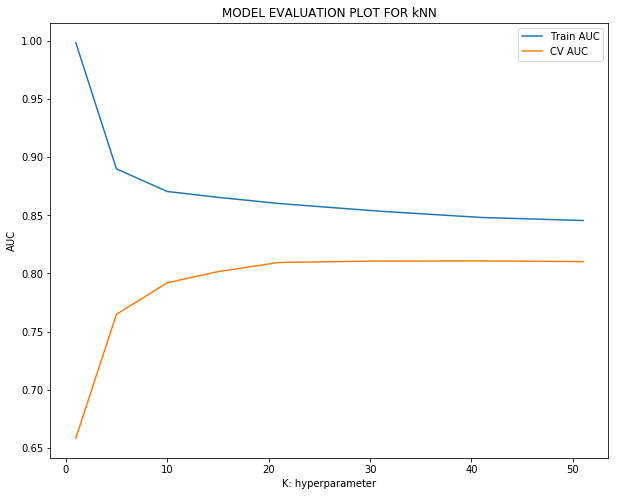

7
Optimal K value for BOW is :  51


In [43]:
optimalK_bow = knn_classifier(bow_train, rs_train, bow_cv, rs_cv, 'brute')
print("Optimal K value for BOW is : ", optimalK_bow)

Using k value in kNN -  51
Train accuracy for optimal kNN using BOW 73.3
Test accuracy for optimal kNN using BOW 71.25


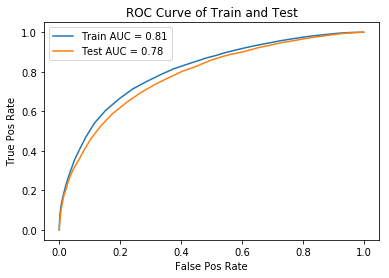

In [44]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for BOW vectors
knn_optimal_bow = KNeighborsClassifier(n_neighbors=optimalK_bow, algorithm='brute')
knn_optimal_bow.fit(bow_train, rs_train)

# Prediction on training and test set using optimal
pred_bow_train = knn_optimal_bow.predict(bow_train)
pred_bow_test = knn_optimal_bow.predict(bow_test)
print("Using k value in kNN - ", optimalK_bow)
print("Train accuracy for optimal kNN using BOW", round(accuracy_score(rs_train, pred_bow_train)*100, 2))
print("Test accuracy for optimal kNN using BOW", round(accuracy_score(rs_test, pred_bow_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_optimal_bow.predict_proba(bow_train)[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_optimal_bow.predict_proba(bow_test)[:, 1], pos_label=1)
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


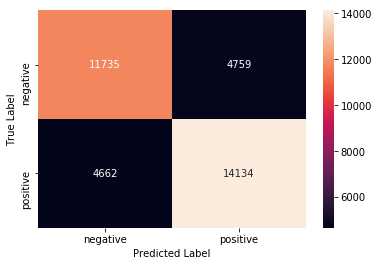




Test Confusion Matrix


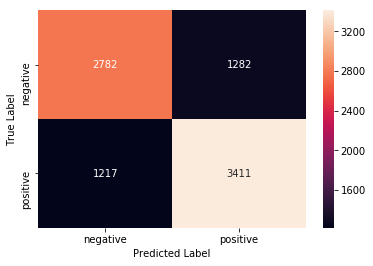

In [45]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_bow_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_bow_test)
table.add_row(["BOW", "Brute", optimalK_bow, auc_score])

In [46]:
# Classification report 
print(classification_report(rs_test, pred_bow_test))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69      4064
           1       0.73      0.74      0.73      4628

   micro avg       0.71      0.71      0.71      8692
   macro avg       0.71      0.71      0.71      8692
weighted avg       0.71      0.71      0.71      8692



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for brute force approach K-Nearest Neighbour. It is found to be 51 for BOW vectors 


- The training accuracy for this value of k comes is 73.3, whereas test accuracy on the test data is 71.25. It shows the model is though not very accurate, but fairly balanced and tuned.


- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 3411+1282+2782+1217 = 8692 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (3411+2782)/8692 ~71.2% as per our recorded observation


- The overall misclassification rate or, error rate is : (False Positives + False Negative) / Total, which is (1282+1217)/8692 ~ 28.7%


- Precision is defined as, how often is the model correct when it predicts something as positive. It is calculated as:
        True Positives/ (True Positives + False Positive) = 3411/(3411+1282) ~ 0.72
        
  Recall is defined as, how much of the positive class data in the whole dataset is the model able to recall correctly. It is also called True Postive Rate(TPR). It is also calculated as:
  
        True Positives/ (True Positives + False Negatives) = 3411/(3411+1217) ~ 0.73
        
  Specificity(also called True Negative Rate) signifies as how correctly the model can correctly identify the data for negative classes. 
  
        True Negatives/ (True Negatives + False Positives) = 2782/(2782+1282) ~ 0.68
        
  False Positive Rate : How often does the model predicts Positives for negatives classes. It is calculated as :
  
        False Positives/ (True Negatives + False Positives) = 1282/(2782+1282) ~ 0.31
  
  All the figures are consistent with our observations


- F1-score : This is a single metric to combine the Precision and Recall values. It is calculated by taking their harmonic mean. The F1-Score figures tell us the model if slightly off for negative classes.
        
- Support : This is the actual number of data points in each of the classes


- Notable Points :

    - For increasing value of K, we see that : the classification error decreases. Also, the AUC score for test data increases and the accuracy curve improves. All these points signify the model to be working good, although the accuracy is not that good.
    
    - Also, from the confusion matrix we see that though the F1-Score for Positive class is good, but it is pretty bad for Negative class due to very high False Negative Rate. Evidently, the model is very bad in recognising negative class of data. 

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

Progress : 100%        


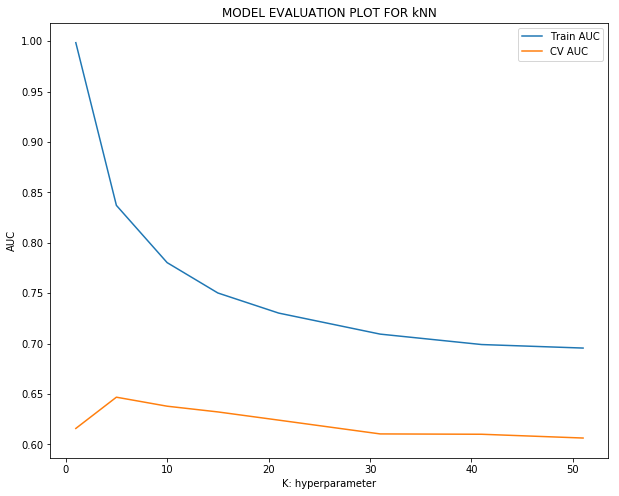

1
Optimal K value for Tf-IDF is :  5


In [47]:
optimalK_tfIdf = knn_classifier(tfIdf_train, rs_train, tfIdf_cv, rs_cv, 'brute')
print("Optimal K value for Tf-IDF is : ", optimalK_tfIdf)

Using k value in kNN -  5
Train accuracy for optimal kNN using TFIDF 75.64
Test accuracy for optimal kNN using TFIDF 60.48


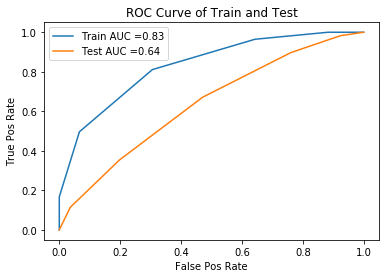

In [49]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for TFIDF vectors
knn_optimal_tf = KNeighborsClassifier(n_neighbors=optimalK_tfIdf, algorithm='brute')
knn_optimal_tf.fit(tfIdf_train, rs_train)

# Prediction on training and test set using optimal
pred_tfIdf_train = knn_optimal_tf.predict(tfIdf_train)
pred_tfIdf_test = knn_optimal_tf.predict(tfIdf_test)
print("Using k value in kNN - ", optimalK_tfIdf)
print("Train accuracy for optimal kNN using TFIDF", round(accuracy_score(rs_train, pred_tfIdf_train)*100, 2))
print("Test accuracy for optimal kNN using TFIDF", round(accuracy_score(rs_test, pred_tfIdf_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_optimal_tf.predict_proba(tfIdf_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_optimal_tf.predict_proba(tfIdf_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


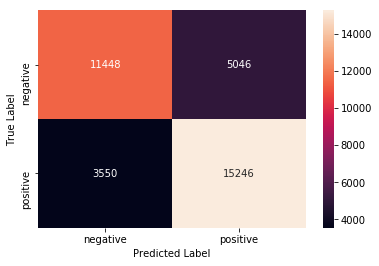




Test Confusion Matrix


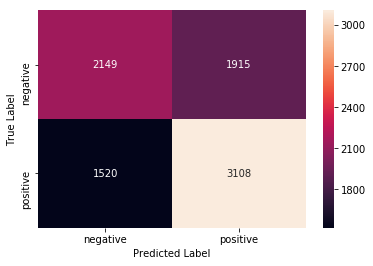

In [50]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tfIdf_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tfIdf_test)
table.add_row(["Tf-Idf", "Brute", optimalK_tfIdf, auc_score])

In [51]:
# Classification report 
print(classification_report(rs_test, pred_tfIdf_test))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56      4064
           1       0.62      0.67      0.64      4628

   micro avg       0.60      0.60      0.60      8692
   macro avg       0.60      0.60      0.60      8692
weighted avg       0.60      0.60      0.60      8692



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for brute force approach K-Nearest Neighbour. It is found to be 5 for tf-IDF vectors 


- The training accuracy for this value of k comes is 75.64, whereas test accuracy on the test data is 60.48. It shows the model is though not very accurate, but fairly balanced and tuned. It is, however, not better than the model working on BOW vectors.


- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 3108+1915+2149+1520 = 8692 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (3108+2149)/8692 ~60.4% as per our recorded observation


- Notable Points :

    - The value of K, decreases drastically for Tf-IDF vectors. Also, the test accuracy decreases drastically.
    
    - Also, from the confusion matrix and classification report we see that the F1-Score are really off for both positive and negative classes, as the False Positives and False Negatives have increased compared to the model using BOW.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

Progress : 100%        


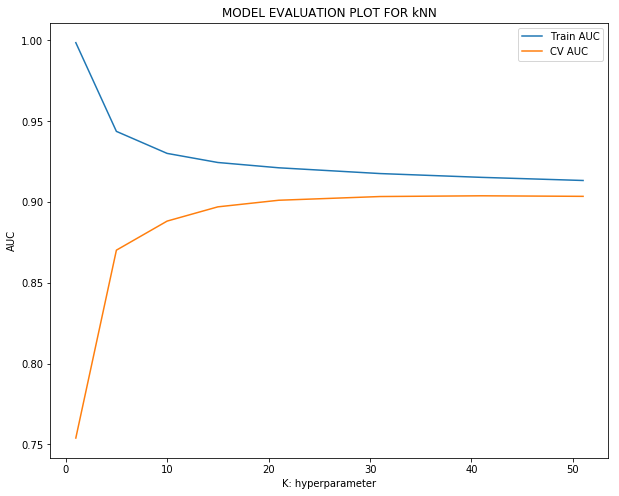

7
Optimal K value for Avg W2V is :  51


In [52]:
# Please write all the code with proper documentation
optimalK_avgWV = knn_classifier(avgWV_vect_train, rs_train, avgWV_vect_cv, rs_cv, 'brute')
print("Optimal K value for Avg W2V is : ", optimalK_avgWV)

Using k value in kNN -  51
Train accuracy for optimal kNN using AvgW2V 83.39
Test accuracy for optimal kNN using AvgW2V 81.81


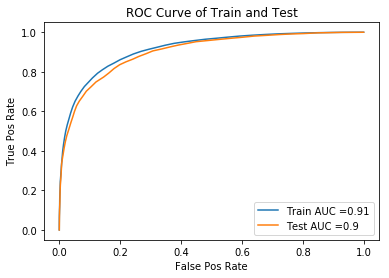

In [53]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for Avg W2V vectors
knn_optimal_avw2v = KNeighborsClassifier(n_neighbors=optimalK_avgWV, algorithm='brute')
knn_optimal_avw2v.fit(avgWV_vect_train, rs_train)

# Prediction on training and test set using optimal
pred_avw2v_train = knn_optimal_avw2v.predict(avgWV_vect_train)
pred_avw2v_test = knn_optimal_avw2v.predict(avgWV_vect_test)
print("Using k value in kNN - ", optimalK_avgWV)
print("Train accuracy for optimal kNN using AvgW2V", round(accuracy_score(rs_train, pred_avw2v_train)*100, 2))
print("Test accuracy for optimal kNN using AvgW2V", round(accuracy_score(rs_test, pred_avw2v_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_optimal_avw2v.predict_proba(avgWV_vect_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_optimal_avw2v.predict_proba(avgWV_vect_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


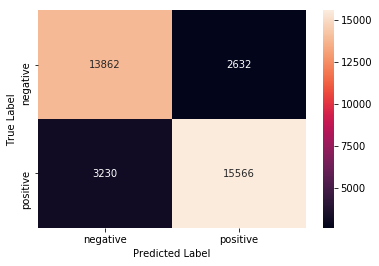




Test Confusion Matrix


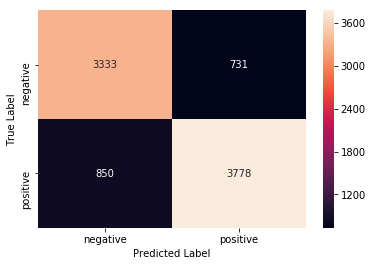

In [54]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_avw2v_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_avw2v_test)
table.add_row(["Avg Word2Vec", "Brute", optimalK_avgWV, auc_score])

In [55]:
# Classification report 
print(classification_report(rs_test, pred_avw2v_test))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4064
           1       0.84      0.82      0.83      4628

   micro avg       0.82      0.82      0.82      8692
   macro avg       0.82      0.82      0.82      8692
weighted avg       0.82      0.82      0.82      8692



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for brute force approach K-Nearest Neighbour. It is found to be 51 for Average Word2Vec vectors 


- The training accuracy for this value of k comes is 83.33%, whereas test accuracy on the unseen data is 81.67%. It shows the model is quite accurate, also fairly balanced and tuned. It is a good improvement against BOW model and also better than tf-IDF model, but we will analyse further.


- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 3751+716+3348+877 = 8692 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (3751+3348)/8692 ~81.6% as per our recorded observation


- Notable Points :

    - The K value, again spikes back to 51. Also, the AUC score for test data increases. We observe a much smoother and gradual curves as compared to the traditional BOW and Tf-IDF models.
    
    - From the confusion matrix, we observe that the false positives and false negatives have largely reduced. So, overall this model is a good improvement over the ones using BOW and tf-IDF vectors.
    
    - The F1-Scores show a good improvement here.

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

Progress : 100%        


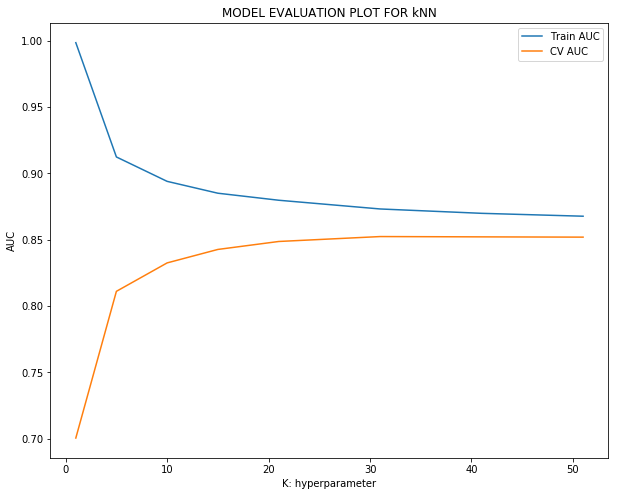

7
Optimal K value for Tf-IDF W2V is :  51


In [56]:
# Please write all the code with proper documentation
optimalK_tfIdfWV = knn_classifier(tfIdfWV_vect_train, rs_train, tfIdfWV_vect_cv, rs_cv, 'brute')
print("Optimal K value for Tf-IDF W2V is : ", optimalK_tfIdfWV)

Using k value in kNN -  51
Train accuracy for optimal kNN using TfIDF-W2V 78.46
Test accuracy for optimal kNN using TfIDF-W2V 76.71


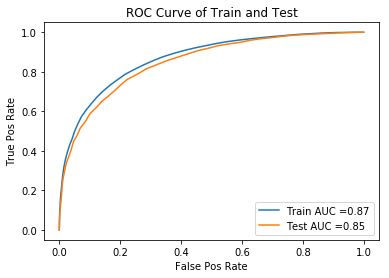

In [60]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for TFIDF-W2V vectors
knn_optimal_tfIdfWV = KNeighborsClassifier(n_neighbors=optimalK_tfIdfWV, algorithm='brute')
knn_optimal_tfIdfWV.fit(tfIdfWV_vect_train, rs_train)

# Prediction on training and test set using optimal
pred_tfIdfWV_train = knn_optimal_tfIdfWV.predict(tfIdfWV_vect_train)
pred_tfIdfWV_test = knn_optimal_tfIdfWV.predict(tfIdfWV_vect_test)
print("Using k value in kNN - ", optimalK_tfIdfWV)
print("Train accuracy for optimal kNN using TfIDF-W2V", round(accuracy_score(rs_train, pred_tfIdfWV_train)*100, 2))
print("Test accuracy for optimal kNN using TfIDF-W2V", round(accuracy_score(rs_test, pred_tfIdfWV_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_optimal_tfIdfWV.predict_proba(tfIdfWV_vect_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_optimal_tfIdfWV.predict_proba(tfIdfWV_vect_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


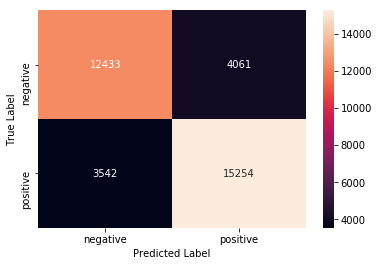




Test Confusion Matrix


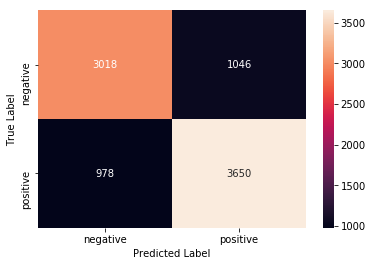

In [61]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tfIdfWV_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tfIdfWV_test)
table.add_row(["Tf-IDF Word2Vec", "Brute", optimalK_tfIdfWV, auc_score])

In [62]:
# Classification report 
print(classification_report(rs_test, pred_tfIdfWV_test))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4064
           1       0.78      0.79      0.78      4628

   micro avg       0.77      0.77      0.77      8692
   macro avg       0.77      0.77      0.77      8692
weighted avg       0.77      0.77      0.77      8692



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for brute force approach K-Nearest Neighbour. It is found to be 51 for Tf-IDF weighted Word2Vec vectors 


- The training accuracy for this value of k comes is 78.4%, whereas test accuracy on the unseen data is 76.9%. It shows the model is though not very accurate, but fairly balanced and tuned. It is a good improvement against Tf-IDF model and almost equal to BOW model, if we only consider the accuracy scores, but we will analyse further.


- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 3659+1039+3025+969 = 8692 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (3659+3025)/8692 ~76.8% on unseen data as per our recorded observation


- Notable Points :

    - The value of K remains same. Also, the AUC score for test data decreases compared to the average Tf-IDF, but it is better compared to others. 
    
    - From the confusion matrix, we can infer that this model is improvement over the ones using BOW and Tf-IDF but not much better than simple Word2Vec.

## [5.2] Applying KNN kd-tree

In [24]:
# Taking 20k datapoints for kd-Tree

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values[:20000]):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)   # adding 0-9 in the regex
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 20000/20000 [00:07<00:00, 2790.54it/s]


In [32]:
#BoW
# this is random splitting into train, test and cross validation set
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_reviews, review_score, 
                                                                    test_size=0.33, random_state = 0) 
ppReview_cv, ppReview_test, rs_cv, rs_test = train_test_split(ppReview_test, rs_test, test_size=0.50, 
                                                              random_state=0)
count_vect = CountVectorizer(min_df=10, max_features=500)    #in scikit-learn
count_vect.fit(ppReview_train)    # fitting done only on training set
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", count_vect.get_feature_names()[:10])

print('='*50)

bow_train = count_vect.transform(ppReview_train)
bow_cv = count_vect.transform(ppReview_cv)
bow_test = count_vect.transform(ppReview_test)

print("\nShapes After Vectorization ")
print(bow_train.shape, len(rs_train))
print(bow_cv.shape, len(rs_cv))
print(bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

Total training features :  500
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'although', 'always']

Shapes After Vectorization 
(13400, 500) 13400
(3300, 500) 3300
(3300, 500) 3300
Unique words in training :  500


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Progress : 100%        


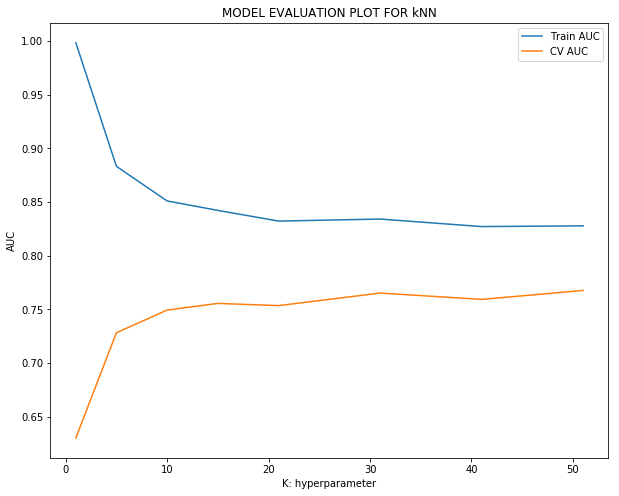

Optimal K value for BOW using kd-Tree algo is :  51


In [36]:
optimalK_bow_kdt = knn_classifier(bow_train.A, rs_train, bow_cv.A, rs_cv, 'kd_tree')
print("Optimal K value for BOW using kd-Tree algo is : ", optimalK_bow_kdt)

Using k value in kNN -  51
Train accuracy for optimal kNN using BOW 75.7
Test accuracy for optimal kNN using BOW 71.12


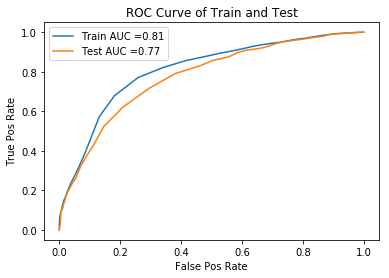

In [37]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for BOW vectors
knn_kdtOptimal_bow = KNeighborsClassifier(n_neighbors=optimalK_bow_kdt, algorithm='kd_tree')
knn_kdtOptimal_bow.fit(bow_train.A, rs_train)

# Prediction on training and test set using optimal
pred_bow_kdt_train = knn_kdtOptimal_bow.predict(bow_train.A)
pred_bow_kdt_test = knn_kdtOptimal_bow.predict(bow_test.A)
print("Using k value in kNN - ", optimalK_bow_kdt)
print("Train accuracy for optimal kNN using BOW", round(accuracy_score(rs_train, pred_bow_kdt_train)*100, 2))
print("Test accuracy for optimal kNN using BOW", round(accuracy_score(rs_test, pred_bow_kdt_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_kdtOptimal_bow.predict_proba(bow_train.A)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_kdtOptimal_bow.predict_proba(bow_test.A)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


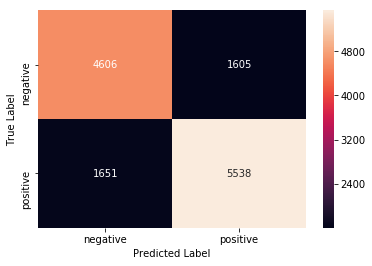




Test Confusion Matrix


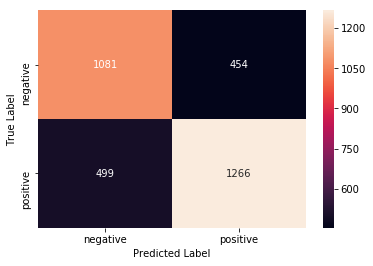

In [38]:
# plot confusion matrix to describe the performance of classifier.

print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_bow_kdt_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_bow_kdt_test)
table.add_row(["BOW", "KD-Tree", optimalK_bow_kdt, auc_score])

In [39]:
# Classification report 
print(classification_report(rs_test, pred_bow_kdt_test))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1535
           1       0.74      0.72      0.73      1765

   micro avg       0.71      0.71      0.71      3300
   macro avg       0.71      0.71      0.71      3300
weighted avg       0.71      0.71      0.71      3300



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for kd-Tree approach K-Nearest Neighbour. It is found to be 51 for BOW vectors 


- The training accuracy for this value of k comes is 75%, whereas test accuracy on the unseen data is 71%. The accuracy of the model increased slightly as compared to the model using brute force approach. Theoretically, the only difference in both is the way they are checking for the neighbours, and there should not be much accuracy difference between them.


- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 1266+454+1081+499 = 3300 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (1266+1081)/3300 ~71.1% on unseen data as per our recorded observation


- Notable Points :
    
    - From the confusion matrix, we can infer that this model is a fairly balanced and fine-tuned.

# [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [40]:
#tf-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(ppReview_train)
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

tfIdf_train = tf_idf_vect.transform(ppReview_train)
tfIdf_cv = tf_idf_vect.transform(ppReview_cv)
tfIdf_test = tf_idf_vect.transform(ppReview_test)
print("\nShapes After Vectorization ")
print(bow_train.shape, len(rs_train))
print(bow_cv.shape, len(rs_cv))
print(bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

Total training features :  500
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'although', 'always']

Shapes After Vectorization 
(13400, 500) 13400
(3300, 500) 3300
(3300, 500) 3300
Unique words in training :  500


Progress : 100%        


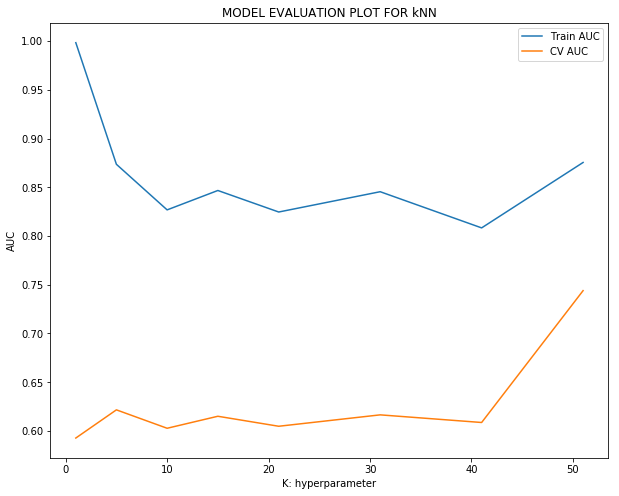

Optimal K value for Tf-IDF using kd-Tree algo is :  51


In [41]:
optimalK_tfIdf_kdt = knn_classifier(tfIdf_train.A, rs_train, tfIdf_cv.A, rs_cv, 'kd_tree')
print("Optimal K value for Tf-IDF using kd-Tree algo is : ", optimalK_tfIdf_kdt)

Using k value in kNN -  51
Train accuracy for optimal kNN using TFIDF 78.3
Test accuracy for optimal kNN using TFIDF 70.0


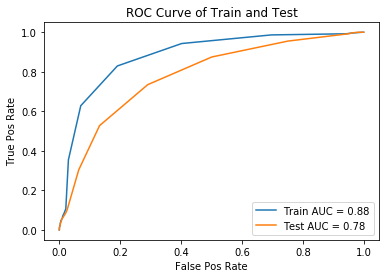

In [42]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for TFIDF vectors
knn_kdtOptimal_tf = KNeighborsClassifier(n_neighbors=optimalK_tfIdf_kdt, algorithm='kd_tree')
knn_kdtOptimal_tf.fit(tfIdf_train.A, rs_train)

# Prediction on training and test set using optimal
pred_tfIdf_kdt_test = knn_kdtOptimal_tf.predict(tfIdf_test.A)
pred_tfIdf_kdt_train = knn_kdtOptimal_tf.predict(tfIdf_train.A)
print("Using k value in kNN - ", optimalK_tfIdf_kdt)
print("Train accuracy for optimal kNN using TFIDF", round(accuracy_score(rs_train, pred_tfIdf_kdt_train)*100, 2))
print("Test accuracy for optimal kNN using TFIDF", round(accuracy_score(rs_test, pred_tfIdf_kdt_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_kdtOptimal_tf.predict_proba(tfIdf_train.A)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_kdtOptimal_tf.predict_proba(tfIdf_test.A)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


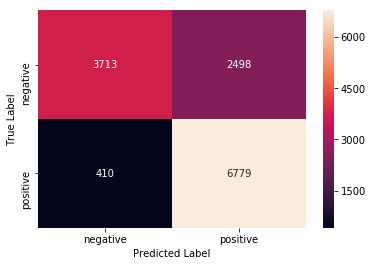




Test Confusion Matrix


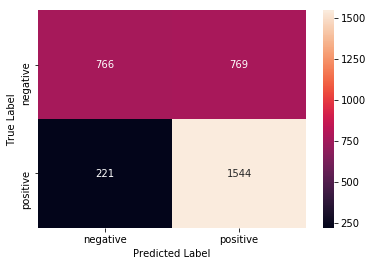

In [43]:
# plot confusion matrix to describe the performance of classifier.

print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tfIdf_kdt_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tfIdf_kdt_test)
table.add_row(["Tf-Idf", "KD-Tree", optimalK_tfIdf_kdt, auc_score])

In [44]:
# Classification report 
print(classification_report(rs_test, pred_tfIdf_kdt_test))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61      1535
           1       0.67      0.87      0.76      1765

   micro avg       0.70      0.70      0.70      3300
   macro avg       0.72      0.69      0.68      3300
weighted avg       0.72      0.70      0.69      3300



#### Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for kd-Tree approach K-Nearest Neighbour. It is found to be 51 for Tf-IDF vectors 


- The training accuracy for this value of k comes is 78.3%, whereas test accuracy on the unseen data is 70%. The accuracy of the model improved fairly as compared to the model using BOW vectors for same k-d Tree approach. Both are having the same approach and same number of features(500), so by the improvement shown by Tf-IDF vectors, we can safely conclude that Tf-IDF vectors are much better.

- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 1544+769+766+221 = 3300 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (1544+766)/3300 ~70% on unseen data as per our recorded observation



- Notable Points :

    - The graph for the AUC and accuracy curves are very random, as we have less features and limited data due to hardware constranits. However, they are better compared to the model on BOW. 
    
    - From the confusion matrix, we can infer after reading the F1-Score, that this model is a very bad predictor of the negative classes.

In [50]:
# Train your own Word2Vec model using your own text corpus
i=0
# list of sentences divide into train, test and cross validation set
list_of_sentance_train=[sentance.split() for sentance in ppReview_train]
list_of_sentance_cv=[sentance.split() for sentance in ppReview_cv]
list_of_sentance_test=[sentance.split() for sentance in ppReview_test]

In [51]:
sent_vectors_train, sent_vectors_test, sent_vectors_cv = [],[],[]
for i, aset in enumerate([list_of_sentance_train, list_of_sentance_cv, list_of_sentance_test]):
    if i==0:
        print("Working on training set")
    elif i==1:
        print("Working on cross validation set")
    elif i==2:
        print("Working on test set")
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length 50
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        if i==0:
            sent_vectors_train.append(sent_vec)
        elif i==1:
            sent_vectors_cv.append(sent_vec)
        elif i==2:
            sent_vectors_test.append(sent_vec)
            
print("Sentences Vectors created..")

Working on training set
Working on cross validation set
Working on test set
Sentences Vectors created..


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [52]:
# Average Word2Vec

avgWV_vect_train = sent_vectors_train
avgWV_vect_cv = sent_vectors_cv
avgWV_vect_test = sent_vectors_test
print("Total training features : ", len(avgWV_vect_train[0]))
print('='*50)

print("\nShapes After Vectorization ")
print("Train Set : (", len(avgWV_vect_train), len(avgWV_vect_train[0]), ")")
print("Test Set : (", len(avgWV_vect_test), len(avgWV_vect_test[0]), ")")
print("CV Set : (", len(avgWV_vect_cv), len(avgWV_vect_cv[0]), ")")

Total training features :  50

Shapes After Vectorization 
Train Set : ( 13400 50 )
Test Set : ( 3300 50 )
CV Set : ( 3300 50 )


Progress : 100%        


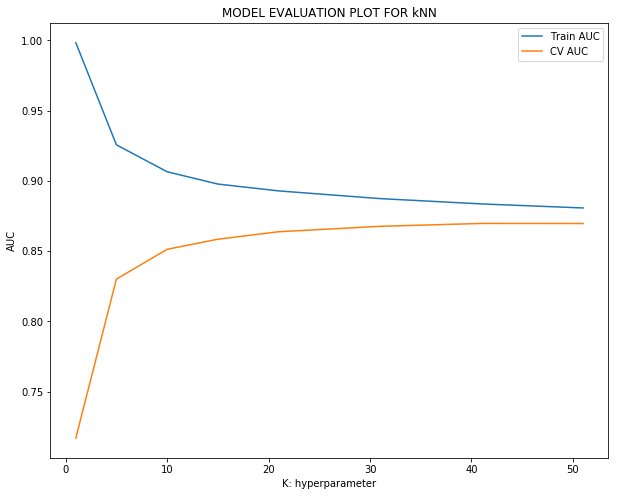

Optimal K value for Avg W2V using kdTree algo is :  51


In [53]:
# Please write all the code with proper documentation
optimalK_avgWV_kdt = knn_classifier(avgWV_vect_train, rs_train, avgWV_vect_cv, rs_cv, 'kd_tree')
print("Optimal K value for Avg W2V using kdTree algo is : ", optimalK_avgWV_kdt)

Using k value in kNN -  51
Train accuracy for optimal kNN using AvgW2V 79.42
Test accuracy for optimal kNN using AvgW2V 78.79


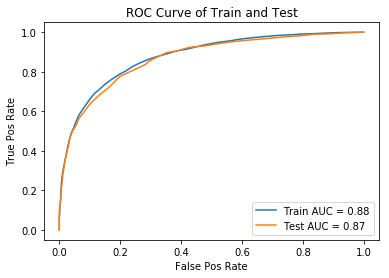

In [54]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for Average W2V vectors
knn_kdtOptimal_avw2v = KNeighborsClassifier(n_neighbors=optimalK_avgWV_kdt, algorithm='kd_tree')
knn_kdtOptimal_avw2v.fit(avgWV_vect_train, rs_train)

# Prediction on training and test set using optimal
pred_avw2v_kdt_train = knn_kdtOptimal_avw2v.predict(avgWV_vect_train)
pred_avw2v_kdt_test = knn_kdtOptimal_avw2v.predict(avgWV_vect_test)
print("Using k value in kNN - ", optimalK_avgWV_kdt)
print("Train accuracy for optimal kNN using AvgW2V", round(accuracy_score(rs_train, pred_avw2v_kdt_train)*100, 2))
print("Test accuracy for optimal kNN using AvgW2V", round(accuracy_score(rs_test, pred_avw2v_kdt_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_kdtOptimal_avw2v.predict_proba(avgWV_vect_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_kdtOptimal_avw2v.predict_proba(avgWV_vect_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


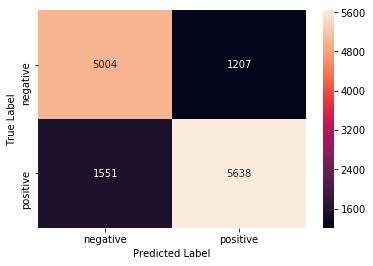




Test Confusion Matrix


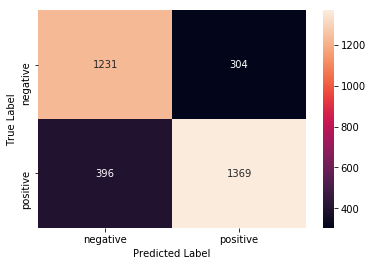

In [55]:
# plot confusion matrix to describe the performance of classifier.

print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_avw2v_kdt_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_avw2v_kdt_test)
table.add_row(["Avg Word2Vec", "KD-Tree", optimalK_avgWV_kdt, auc_score])

In [56]:
# Classification report 
print(classification_report(rs_test, pred_avw2v_kdt_test))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1535
           1       0.82      0.78      0.80      1765

   micro avg       0.79      0.79      0.79      3300
   macro avg       0.79      0.79      0.79      3300
weighted avg       0.79      0.79      0.79      3300



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for kd-Tree approach K-Nearest Neighbour. It is found to be 51 for Average Word2Vec vectors 


- The training accuracy for this value of k comes is 79%, whereas test accuracy on the unseen data is 78%. The accuracy of the model is comparable to the BOW and Tf-IDF models, but F1 scores will give a clearer picture.

- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 1369+304+1231+396 = 3300 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (1369+1231)/3300 ~78% on unseen data as per our recorded observation



- Notable Points :

    - The graph for the AUC and accuracy curves are much smooth compared to the previous models but the F1-score improved drastically, which shows that this model is better predictor of the negative classs values.

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [57]:
model = TfidfVectorizer(min_df=10, max_features=500)
# fit transform only on training set
tf_idf_matrix = model.fit_transform(ppReview_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfsent_vectors_train, tfsent_vectors_test, tfsent_vectors_cv = [],[],[]
for i, aset in enumerate([list_of_sentance_train, list_of_sentance_cv, list_of_sentance_test]):
    if i==0:
        print("Working on training set")
    elif i==1:
        print("Working on cross validation set")
    elif i==2:
        print("Working on test set")
    rows=0
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length 50
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        if i==0:
            tfsent_vectors_train.append(sent_vec)
        elif i==1:
            tfsent_vectors_cv.append(sent_vec)
        elif i==2:
            tfsent_vectors_test.append(sent_vec)
        rows+=1
            
print("Sentences Vectors created..")

Working on training set
Working on cross validation set
Working on test set
Sentences Vectors created..


In [59]:
# Tf-IDF Weighted Word2Vec

tfIdfWV_vect_train = tfsent_vectors_train
tfIdfWV_vect_cv = tfsent_vectors_cv
tfIdfWV_vect_test = tfsent_vectors_test
print("Total training features : ", len(tfIdfWV_vect_train[0]))
print('='*50)

print("\nShapes After Vectorization ")
print("Train Set : (", len(tfIdfWV_vect_train), len(tfIdfWV_vect_train[0]), ")")
print("Test Set : (", len(tfIdfWV_vect_test), len(tfIdfWV_vect_test[0]), ")")
print("CV Set : (", len(tfIdfWV_vect_cv), len(tfIdfWV_vect_cv[0]), ")")

Total training features :  50

Shapes After Vectorization 
Train Set : ( 13400 50 )
Test Set : ( 3300 50 )
CV Set : ( 3300 50 )


Progress : 100%        


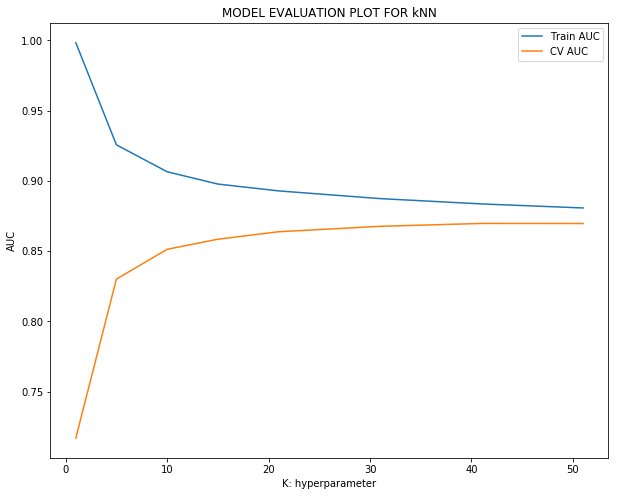

Optimal K value for Tf-IDF W2V using kdTree algo is :  51


In [60]:
# Please write all the code with proper documentation
optimalK_tfIdfWV_kdt = knn_classifier(avgWV_vect_train, rs_train, avgWV_vect_cv, rs_cv, 'kd_tree')
print("Optimal K value for Tf-IDF W2V using kdTree algo is : ", optimalK_tfIdfWV_kdt)

Using k value in kNN -  51
Train accuracy for optimal kNN using Tf-IDF W2V 76.29
Test accuracy for optimal kNN using Tf-IDF W2V 76.3


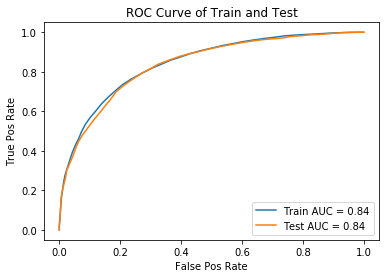

In [61]:
# training the optimal KNeighbourClassifier using optimal number of neighbours for Tf-IDF W2V vectors
knn_kdtOptimal_tfIdfWV = KNeighborsClassifier(n_neighbors=optimalK_tfIdfWV_kdt, algorithm='kd_tree')
knn_kdtOptimal_tfIdfWV.fit(tfIdfWV_vect_train, rs_train)

# Prediction on training and test set using optimal
pred_tfIdfWV_kdt_train = knn_kdtOptimal_tfIdfWV.predict(tfIdfWV_vect_train)
pred_tfIdfWV_kdt_test = knn_kdtOptimal_tfIdfWV.predict(tfIdfWV_vect_test)
print("Using k value in kNN - ", optimalK_tfIdfWV_kdt)
print("Train accuracy for optimal kNN using Tf-IDF W2V", round(accuracy_score(rs_train, pred_tfIdfWV_kdt_train)*100, 2))
print("Test accuracy for optimal kNN using Tf-IDF W2V", round(accuracy_score(rs_test, pred_tfIdfWV_kdt_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, knn_kdtOptimal_tfIdfWV.predict_proba(tfIdfWV_vect_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(rs_test, knn_kdtOptimal_tfIdfWV.predict_proba(tfIdfWV_vect_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


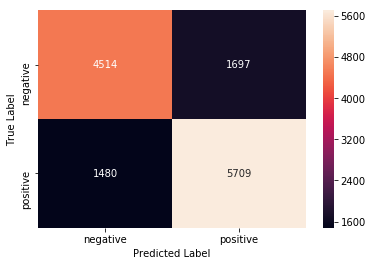




Test Confusion Matrix


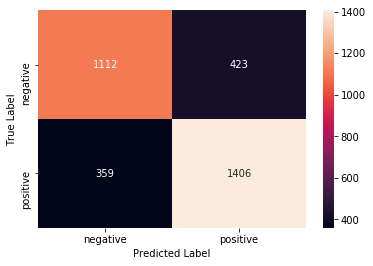

In [62]:
# plot confusion matrix to describe the performance of classifier.

print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tfIdfWV_kdt_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tfIdfWV_kdt_test)
table.add_row(["Tf-IDF Word2Vec", "KD-Tree", optimalK_tfIdfWV_kdt, auc_score])

In [63]:
# Classification report 
print(classification_report(rs_test, pred_tfIdfWV_kdt_test))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1535
           1       0.77      0.80      0.78      1765

   micro avg       0.76      0.76      0.76      3300
   macro avg       0.76      0.76      0.76      3300
weighted avg       0.76      0.76      0.76      3300



# Observations

- We use the cross validation method on ROC-AUC curve to get the optimal value of k for kd-Tree approach K-Nearest Neighbour. It is found to be 51 for Tf-IDF weighted Word2Vec vectors 


- The training accuracy for this value of k comes is 76%, whereas test accuracy on the unseen data is also around 76%. The accuracy of the model is comparable to the BOW and Tf-IDF models, but F1 scores will give a clearer picture.

- In the confusion matrix the total test datasets are calculated as: <br>
            True Positives + False Postives + True Negatives + False Negatives
  which are calculated as 1406+423+1112+359 = 3300 (our actual number of test data sets)


- Overall model accuracy is : (True Positives + True Negatives) / Total, which is (1406+1112)/3300 ~76.3% on unseen data as per our recorded observation



- Notable Points :

    - From the confusion matrix, we can infer after reading the F1-Score, that this model is improvement over the ones using BOW and Tf-IDF but not much better than simple Word2Vec.

# [6] Conclusions

In [72]:
# Please compare all your models using Prettytable library
print(table)

+-----------------+---------+-----------------+-----------+
|    Vectorizer   |  Model  | Hyperparameters | AUC Score |
+-----------------+---------+-----------------+-----------+
|       BOW       | KD-Tree |        51       |    0.77   |
|      Tf-Idf     | KD-Tree |        51       |    0.78   |
|   Avg Word2Vec  | KD-Tree |        51       |    0.87   |
| Tf-IDF Word2Vec | KD-Tree |        51       |    0.84   |
|       BOW       |  Brute  |        51       |    0.78   |
|      Tf-Idf     |  Brute  |        5        |    0.64   |
|   Avg Word2Vec  |  Brute  |        51       |    0.9    |
| Tf-IDF Word2Vec |  Brute  |        51       |    0.85   |
+-----------------+---------+-----------------+-----------+
